## Installing Dependencies

In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
# !pip list

In [3]:
print("hi")

hi


In [4]:
import os
import cv2
import tensorflow as tf # type: ignore
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try :
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
     pass

## 1. Build Data Loading Functions:

In [7]:
import gdown

In [ ]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=df6aca61-2913-4e5e-9c08-a9e5d8b6bdf8
To: c:\Users\Admin\My_projects\Lip_Reading_project\data.zip
 25%|██▍       | 105M/423M [01:18<05:03, 1.05MB/s] 

KeyboardInterrupt: 

In [9]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        # convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # frame = tf.image.rgb_to_gray_scale(frame)
        frames.append(frame[190:236, 80:220])
    cap.release()
    
    mean  = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames- mean ), tf.float32) / std
    

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
# oov_token is out of library vocabulary token the default value is -1

print(
    f"The vocabulary is {char_to_num.get_vocabulary()} and the size is {char_to_num.vocabulary_size()}"
)

The vocabulary is ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] and the size is 39


In [12]:
vocab_size = char_to_num.vocabulary_size()
vocab_size

39

In [13]:
def load_alignments(path: str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.strip().split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    # print(tokens)
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1)))[1:]
    # return char_to_num(tf.strings.unicode_split(tokens, input_encoding="UTF-8"))

In [14]:
tokens = [' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'f', ' ', 'two', ' ', 'now']

In [15]:
load_alignments(r"data\alignments\s1\bbaf2n.align")

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38,  6, 38, 20, 23, 15,
       38, 14, 15, 23])>

In [16]:
def load_data(path: str): 
    path = tf.convert_to_tensor(path).numpy().decode('utf-8')
    # #file_name = path.split('/')[-1].split('.')[0]
    # # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # print(video_path)
    # print(alignment_path)
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
test_path = r'data\alignments\s1\bbaf2n.align'

In [18]:
frames, alignments = load_data(test_path)

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38,  6, 38, 20, 23, 15,
       38, 14, 15, 23])>

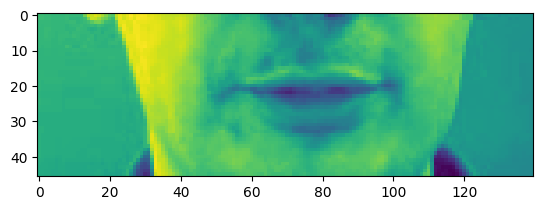

In [20]:
plt.imshow(frames[40])

In [21]:
tf.strings.reduce_join([num_to_char(x).numpy().decode('utf-8') for x in alignments.numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 2. Create Data Pipeline:

In [23]:
data = tf.data.Dataset.list_files('data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration= False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [24]:
frames, alignments = data.as_numpy_iterator().next()

In [25]:
test = data.as_numpy_iterator()

In [26]:
val = test.next()
val[0]

array([[[[ 0.27658132,  0.27658132,  0.23706971, ..., -0.829744  ,
          -0.829744  , -0.829744  ],
         [ 0.35560456,  0.31609294,  0.23706971, ..., -0.829744  ,
          -0.829744  , -0.829744  ],
         [ 0.23706971,  0.23706971,  0.19755809, ..., -0.829744  ,
          -0.8692556 , -0.8692556 ],
         ...,
         [-0.23706971, -0.23706971, -0.23706971, ..., -1.0668137 ,
          -1.027302  , -1.027302  ],
         [-0.23706971, -0.23706971, -0.23706971, ..., -1.0668137 ,
          -1.027302  , -1.027302  ],
         [-0.23706971, -0.23706971, -0.23706971, ..., -1.0668137 ,
          -1.027302  , -1.0668137 ]],

        [[ 0.19755809,  0.07902323,  0.15804647, ..., -0.829744  ,
          -0.8692556 , -0.8692556 ],
         [ 0.19755809,  0.03951162,  0.15804647, ..., -0.829744  ,
          -0.8692556 , -0.8692556 ],
         [ 0.19755809,  0.19755809,  0.15804647, ..., -0.829744  ,
          -0.8692556 , -0.8692556 ],
         ...,
         [-0.23706971, -0.27658132

In [27]:
val[1][0]

array([ 2,  9, 14, 38,  7, 18,  5,  5, 14, 38,  2, 25, 38,  8, 38,  6, 15,
       21, 18, 38, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [28]:
imageio.mimsave('.\\animation.gif', val[0][1], fps = 10)

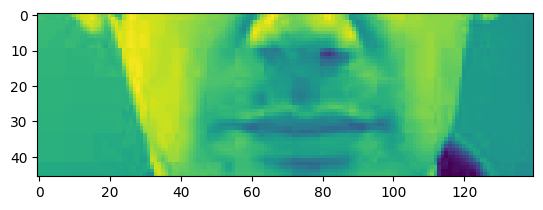

In [29]:
plt.imshow(val[0][0][0])

In [30]:
val_uint8 = (val[0][1] * 60).astype(np.uint8) 
if val_uint8.shape[-1] == 1:  # If single channel, convert to RGB
    val_uint8 = np.repeat(val_uint8, 3, axis=-1)  # Repeat grayscale across 3 channels
elif val_uint8.shape[-1] != 3:
    raise ValueError("Unexpected number of image channels. Expected 1 or 3.")

imageio.mimsave('./animation.gif', val_uint8, fps=10)

ValueError: Unexpected number of image channels. Expected 1 or 3.

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by h four now'>

## 3. Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape = (75, 46, 140,1), padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding = 'same', activation= 'relu'))
model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))
model.add(Reshape((-1, np.prod(model.output_shape[2:]))))

model.add(Bidirectional(LSTM(128, kernel_initializer= 'Orthogonal', return_sequences= True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer= 'Orthogonal', return_sequences= True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_1 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 40)         │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,667 (32.32 MB)

 Trainable params: 8,471,667 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [38]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 18, 18, 34])>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, np.int64(75), 40)

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'5555555555555555555555555555555555555555555555555555555555555555555555rrrrr'>

In [42]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]).numpy()

b'555555555555555555555555555555555555555555555555555555555555555555555555rr6'

In [43]:
print(yhat.shape[0])
print(yhat[0].shape)
print(yhat[1].shape)

2
(75, 40)
(75, 40)


In [44]:
model.input_shape

(None, 75, 46, 140, 1)

## 4. Setup Training Options and Train:

In [45]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [46]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [47]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [48]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [49]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [50]:
schedule_callback = LearningRateScheduler(scheduler)

In [51]:
example_callback = ProduceExample(data)

In [52]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


 25%|██▍       | 105M/423M [06:49<20:34, 258kB/s] 


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 102.3826

ValueError: Unrecognized data type: x=NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000012BBC674590>) (of type <class 'tensorflow.python.data.ops.dataset_ops.NumpyIterator'>)